# Machine Learning Optimization: 

We will use Classification Analysis to see if we can predict the type of neighborhood Tier1(Medium - High Priced House) and Tier2(Below Medium Priced Houses) based on metrics such as the diversity of restaurant categories, the location, the number of reviews, number of ratings, yelp pricing levels etc. 

Understanding the type of neighborhood can help restaurants figure out where their restaurants will be successful. It also helps them in pricing decisions as higher priced house demographic have higher disposable income. 

We will use classificaton algorithms, a type of supervised machine learning that uses labelled data to predict the likelihood that subsequent data will fall into one of the predetermined categories. 

#### Machine Learning Models
We will use five machine learning models to determine which can give the an accurate result. 

1. Logistic Regression 
2. Random Forest
3. Adaboost
4. Gradient Boost
5. Naive Bayes

#### Feature Engineering 
**Part I**

Part I of Feature Engineering was done separately in the following notebooks using the ETL(Extract, Transform, Load) technique.
1. Yelp and Housing data 
    - Housing data from zillow and redfin were cleaned and merged to extract 2021 housing price per zipcode. 
    **Notebooks**: Redfin_Cleaning_Zillow_Merge.ipynb, Zillow_Cleaning.ipynb
    - Yelp data was pulled for 6014 zipcodes through Yelp Fusion API, cleaned, and transformed to show 211 restaurant categories, pricing, yelp star rating and yelp reviews per zip code. The data was then merged with housing data. 
    **Notebooks**: Restaurant_data_merge_and_clean.ipynb, Yelp_zipcode_api_pull.ipynb, Final_Yelp_API_Data_Corrected_Clean.ipynb
    
2. Neighborhood Tiers
    - Two Tiers - Tier1 and Tier2 was created by dividing each postal_code's house price by the corresponding State's mean house price. This gives us a multiplier for each house price in the dataframe which was used to create the tiers. 

**Part II**

To optimize the model we will create the feature set with the following features. The rationale behind this approach is because we saw when we ran the random forest classifier in the previous, that these features were given the highest importance

* Drop counties that have less than 10 zipcodes

**Feature Selection**
* total_restaurants
* total_reviews
* num_rest_categories
* all the stars ratio: 
    - ratio_stars_1.0
    - ratio_stars_1.5
    - ratio_stars_2.0
    - ratio_stars_2.5
    - ratio_stars_3.0
    - ratio_stars_3.5
    - ratio_stars_4.0
    - ratio_stars_4.5
    - ratio_stars_5.0'

**Part III**

Using Standard Scalar, we will scale the model and transform the data in such a manner that it has mean as 0 and standard deviation as 1. 

The data is now ready to run the models. 

#### Model Evaluation 
We will select the best model for our prediction based on the following metrics. 

**Confusion Matrix**
A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. 
- True Positives (TP) - # correctly predicted event values.
- True Negatives (TN) - # correctly predicted no-event values.
- False Positive (FP) - # for incorrectly predicted event values.
- False Negative (FN) - # incorrectly predicted no-event values.

**Classification Report**
The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem.

The four metrics are:

* Precision = TP / (TP + FP) : measures how accurate the predictions are
* Recall = TP / (TP + FN) : % of positives correctly identified
* F1-score = 2 x (precision x recall)/(precision + recall): Harmonic mean of precision and recall.
* Support - Support is the number of actual occurrences of the class in the specified dataset.

**Feature Importance**
Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

In [1]:
#import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
#Read in the CSV and read in the data
df = pd.read_csv("../Neighborhood/neighborhood_two_tier_state_final.csv")

In [3]:
df.head()

,postal_code,City,State,CountyName,2021,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types,Average State House Price,Neighborhood Indicator,Neighborhood Tiers
0,1267.0,Williamstown,MA,Berkshire County,357029.0,23,1347.0,3.782609,1.0,2.0,0.0,4.0,14.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,5.0,11.0,3.0,1.0,23,488930.0,0.730225,2
1,2134.0,Boston,MA,Suffolk County,620830.0,1,2.0,4.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,488930.0,1.269773,1
2,2886.0,Warwick,RI,Kent County,315398.0,1,28.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,315398.0,1.000000,2
3,3079.0,Salem,NH,Rockingham County,458081.0,1,1.0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,370626.0,1.235966,1
4,3276.0,Northfield,NH,Merrimack County,283171.0,1,1.0,2.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,370626.0,0.764034,2


In [4]:
df.shape

(13988, 29)

In [5]:
df.City.value_counts()

New York                       178
Houston                        107
Los Angeles                    100
San Antonio                     56
Chicago                         56
Dallas                          51
Austin                          48
Phoenix                         48
Philadelphia                    47
Las Vegas                       46
Columbus                        46
Kansas City                     43
Washington                      40
Louisville                      39
Jacksonville                    37
Springfield                     36
Indianapolis                    35
Oklahoma City                   35
Portland                        34
San Diego                       34
Arlington                       33
Omaha                           32
Nashville                       32
Jackson                         32
Cleveland                       32
Denver                          32
Detroit                         31
Lexington                       30
San Jose            

In [6]:
#df_ml = df.groupby('City').filter(lambda x : len(x)>=10)
#df_ml.shape

In [7]:
df.columns.to_list()

['postal_code',
 'City',
 'State',
 'CountyName',
 '2021',
 'total_restaurants',
 'total_reviews',
 'avg_rating',
 'total_delivery',
 'total_pickup',
 'total_rest_reservation',
 'total_price_1',
 'total_price_2',
 'total_price_3',
 'total_price_4',
 'total_0.0_stars',
 'total_1.0_stars',
 'total_1.5_stars',
 'total_2.0_stars',
 'total_2.5_stars',
 'total_3.0_stars',
 'total_3.5_stars',
 'total_4.0_stars',
 'total_4.5_stars',
 'total_5.0_stars',
 'num_rest_types',
 'Average State House Price',
 'Neighborhood Indicator',
 'Neighborhood Tiers']

# Feature Engineering

In [8]:
#Drop counties that have less than 10 zipcodes
df = df.groupby('CountyName').filter(lambda x : len(x)>10)
df.shape

(9952, 29)

### Create Scaled Training and Test data

In [9]:
# Create the features
X = df[['total_restaurants',
 'total_reviews',
 'avg_rating',
 'total_delivery',
 'total_pickup',
 'total_rest_reservation',
 'total_price_1',
 'total_price_2',
 'total_price_3',
 'total_price_4',
 'total_0.0_stars',
 'total_1.0_stars',
 'total_1.5_stars',
 'total_2.0_stars',
 'total_2.5_stars',
 'total_3.0_stars',
 'total_3.5_stars',
 'total_4.0_stars',
 'total_4.5_stars',
 'total_5.0_stars',
 'num_rest_types']]
X.head()

,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types
1,1,2.0,4.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,1,28.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,41,322.0,3.780488,0.0,0.0,0.0,11.0,16.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,6.0,17.0,7.0,3.0,21
6,13,40.0,3.500000,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5.0,2.0,1.0,9
7,19,82.0,3.736842,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,10.0,3.0,0.0,19


In [10]:
X.describe()

,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types
count,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.000000,9952.00000,9952.000000
mean,19.570941,3004.343047,3.860911,13.553658,7.526226,0.224377,5.486837,8.112440,0.558380,0.106612,0.004622,0.290695,0.350181,0.655044,0.978296,1.694333,3.497990,6.139168,4.414791,1.54582,18.447247
std,24.742448,8428.358978,0.542880,20.468950,13.498889,0.879195,7.835923,12.231911,1.796559,0.613705,0.067833,0.836559,0.991402,1.534475,2.056857,2.855093,5.158487,9.209496,6.477249,2.21026,16.419870
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.000000,50.000000,3.543323,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,5.000000
50%,10.000000,454.000000,3.945553,4.000000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,2.000000,1.00000,14.000000
75%,27.000000,2354.250000,4.166667,20.000000,10.000000,0.000000,7.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,5.000000,8.000000,6.000000,2.00000,28.000000
max,230.000000,272071.000000,5.000000,189.000000,163.000000,19.000000,72.000000,110.000000,37.000000,29.000000,1.000000,11.000000,18.000000,20.000000,22.000000,30.000000,51.000000,105.000000,90.000000,29.00000,96.000000


In [11]:
#Create target variable
y = df['Neighborhood Tiers']
y.head()

1    1
2    2
5    1
6    1
7    2
Name: Neighborhood Tiers, dtype: int64

In [12]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")


y_train: Counter({1: 4229, 2: 3235})
y_test: Counter({1: 1365, 2: 1123})


In [13]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
X_train_scaled[:, 2]

array([-0.04248916,  0.64976084,  0.01158969, ...,  0.56234013,
        0.59015581,  1.17428506])

In [15]:
X_test_scaled[:,2]

array([-0.42114279, -0.20259103, -1.12050843, ...,  0.48584701,
        0.25636767,  0.12523661])

# Create a logistic regression model

In [16]:
# Logistic Regression
classifier_LR = LogisticRegression(solver='lbfgs', random_state=1, max_iter = 200)
classifier_LR

LogisticRegression(max_iter=200, random_state=1)

In [17]:
# Train the data
classifier_LR.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [18]:
# Predict outcomes for test data set
y_pred_LR = classifier_LR.predict(X_test_scaled)
pd.DataFrame({"Prediction": y_pred_LR, "Actual": y_test}).head(20)

,Prediction,Actual
8238,1,1
2291,2,1
10958,2,1
5677,2,2
13335,1,1
3742,1,1
12814,1,2
351,2,1
1149,2,1
8418,1,2


In [19]:
#Calculate the Balanced Accuracy score
y_pred = classifier_LR.predict(X_test_scaled)
acc_LR = accuracy_score(y_test, y_pred_LR)
acc_LR

0.6434887459807074

In [20]:
#calculate Mean Squared Error
mse_LR = mean_squared_error(y_test, y_pred_LR)
mse_LR

0.3565112540192926

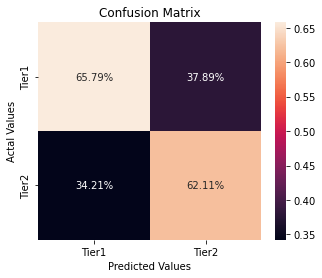

In [25]:
# Display the confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_LR = pd.DataFrame(cm_LR,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
#sns.heatmap(cm_df_LR, annot=True)
sns.heatmap(cm_df_LR/np.sum(cm_df_LR), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [26]:
# Print the classification report
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           1       0.66      0.73      0.69      1365
           2       0.62      0.54      0.58      1123

    accuracy                           0.64      2488
   macro avg       0.64      0.63      0.63      2488
weighted avg       0.64      0.64      0.64      2488



# Create Balanced Random Forest Classifier

In [27]:
# Resample the training data with the BalancedRandomForestClassifier
model_RF = BalancedRandomForestClassifier(n_estimators=50, random_state=1) 
model_RF.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(n_estimators=50, random_state=1)

In [29]:
# Calculated the balanced accuracy score
y_pred_RF = model_RF.predict(X_test_scaled)

accuracy_score(y_test, y_pred_RF)


0.6583601286173634

In [30]:
#calculate Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
mse_RF

0.34163987138263663

In [31]:
pd.DataFrame({"Prediction": y_pred_RF, "Actual": y_test}).head(20)

,Prediction,Actual
8238,1,1
2291,2,1
10958,2,1
5677,2,2
13335,1,1
3742,2,1
12814,1,2
351,1,1
1149,1,1
8418,1,2


In [32]:
# Calculate feature importance in the Random Forest model.
importances = model_RF.feature_importances_
importances

array([0.06355167, 0.20156863, 0.08495066, 0.06253751, 0.05405515,
       0.00821764, 0.06829925, 0.06477953, 0.02051747, 0.0054411 ,
       0.00080084, 0.01398527, 0.01312483, 0.01879136, 0.0241739 ,
       0.03210818, 0.04176899, 0.04950789, 0.04714121, 0.0368824 ,
       0.08779653])

In [33]:
# We can sort the features by their importance.
sorted(zip(model_RF.feature_importances_, X.columns), reverse=True)


[(0.20156862888857396, 'total_reviews'),
 (0.0877965323062316, 'num_rest_types'),
 (0.08495066181514939, 'avg_rating'),
 (0.06829925238553676, 'total_price_1'),
 (0.06477952994275514, 'total_price_2'),
 (0.06355167450935553, 'total_restaurants'),
 (0.06253750934192345, 'total_delivery'),
 (0.05405514542130132, 'total_pickup'),
 (0.04950789088667796, 'total_4.0_stars'),
 (0.04714120776335189, 'total_4.5_stars'),
 (0.04176898647982725, 'total_3.5_stars'),
 (0.0368823954082184, 'total_5.0_stars'),
 (0.032108176231722935, 'total_3.0_stars'),
 (0.024173898241000316, 'total_2.5_stars'),
 (0.02051746922841458, 'total_price_3'),
 (0.01879136363396507, 'total_2.0_stars'),
 (0.013985269612077945, 'total_1.0_stars'),
 (0.01312482584158077, 'total_1.5_stars'),
 (0.008217644335419954, 'total_rest_reservation'),
 (0.005441099424464826, 'total_price_4'),
 (0.0008008383024508766, 'total_0.0_stars')]

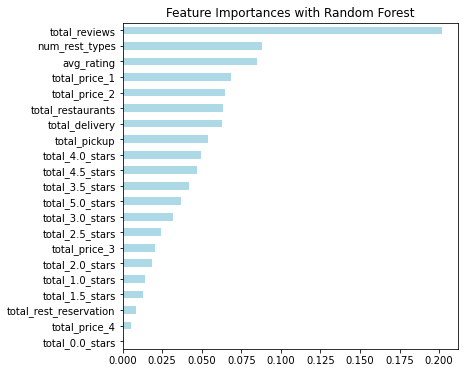

In [34]:
# Plot influential features based on Random Forest model:
influential_features = pd.Series(model_RF.feature_importances_, X.columns)
influential_features.nlargest(25).sort_values().plot(kind='barh', color='lightblue', figsize=(6,6))
plt.title('Feature Importances with Random Forest');


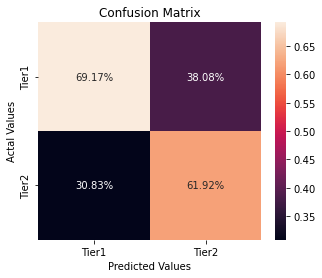

In [35]:
# Display the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_RF = pd.DataFrame(cm_RF,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_RF/np.sum(cm_df_RF), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
# Print the classification report
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           1       0.69      0.68      0.69      1365
           2       0.62      0.63      0.63      1123

    accuracy                           0.66      2488
   macro avg       0.66      0.66      0.66      2488
weighted avg       0.66      0.66      0.66      2488



# Create Easy Ensemble AdaBoost Classifier

In [37]:
# Train the EasyEnsembleClassifier
model_Ada = EasyEnsembleClassifier(n_estimators=75, random_state=1) 
model_Ada.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=75, random_state=1)

In [38]:
# Calculated the balanced accuracy score
y_pred_Ada = model_Ada.predict(X_test_scaled)

balanced_accuracy_score(y_test, y_pred_Ada)

0.6564513551156472

In [39]:
pd.DataFrame({"Prediction": y_pred_Ada, "Actual": y_test}).head(10)

,Prediction,Actual
8238,1,1
2291,2,1
10958,2,1
5677,2,2
13335,1,1
3742,1,1
12814,1,2
351,1,1
1149,2,1
8418,1,2


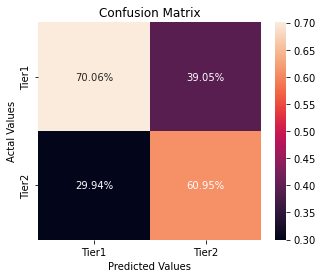

In [40]:
# Display the confusion matrix
cm_Ada = confusion_matrix(y_test, y_pred_Ada)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_Ada = pd.DataFrame(cm_Ada,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_Ada/np.sum(cm_df_Ada), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [41]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_Ada))

              precision    recall  f1-score   support

           1       0.70      0.65      0.68      1365
           2       0.61      0.66      0.63      1123

    accuracy                           0.66      2488
   macro avg       0.66      0.66      0.65      2488
weighted avg       0.66      0.66      0.66      2488



# Create Gradient Boosting Classifier

In [42]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier_GBC = GradientBoostingClassifier(n_estimators=20,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            random_state=0)
    # Fit the model
    classifier_GBC.fit(X_train_scaled, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier_GBC.score(
            X_train_scaled,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier_GBC.score(
            X_test_scaled,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.660
Accuracy score (validation): 0.631

Learning rate:  0.1
Accuracy score (training): 0.674
Accuracy score (validation): 0.650

Learning rate:  0.25
Accuracy score (training): 0.685
Accuracy score (validation): 0.651

Learning rate:  0.5
Accuracy score (training): 0.689
Accuracy score (validation): 0.662

Learning rate:  0.75
Accuracy score (training): 0.699
Accuracy score (validation): 0.655

Learning rate:  1
Accuracy score (training): 0.699
Accuracy score (validation): 0.656



In [43]:
# Choose a learning rate and create classifier
classifier_GBC = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.75,
                                        max_features=10,
                                        max_depth=5,
                                        random_state=0)

# Fit the model
classifier_GBC.fit(X_train_scaled, y_train)

# Make Prediction
y_pred_GBC = classifier_GBC.predict(X_test_scaled)
pd.DataFrame({"Prediction": y_pred_GBC, "Actual": y_test}).head(20)

,Prediction,Actual
8238,1,1
2291,1,1
10958,2,1
5677,2,2
13335,1,1
3742,1,1
12814,2,2
351,1,1
1149,2,1
8418,1,2


In [44]:
accuracy_score(y_test, y_pred_GBC)

0.637459807073955

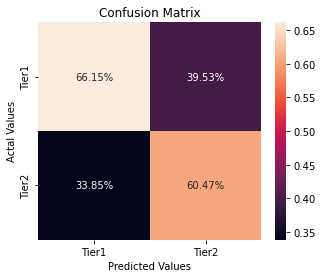

In [45]:
cm_GBC = confusion_matrix(y_test, y_pred_GBC)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_GBC = pd.DataFrame(cm_GBC,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_GBC/np.sum(cm_df_GBC), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [46]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_GBC))


              precision    recall  f1-score   support

           1       0.66      0.69      0.68      1365
           2       0.60      0.57      0.59      1123

    accuracy                           0.64      2488
   macro avg       0.63      0.63      0.63      2488
weighted avg       0.64      0.64      0.64      2488



# Naive Bayes model

In [47]:
from sklearn.naive_bayes import GaussianNB
classifiers_bayes = GaussianNB()
classifiers_bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [48]:
y_pred_bayes  =  classifiers_bayes.predict(X_test_scaled)

In [49]:
pd.DataFrame({"Prediction": y_pred_bayes, "Actual": y_test}).head(20)

,Prediction,Actual
8238,1,1
2291,2,1
10958,2,1
5677,2,2
13335,2,1
3742,1,1
12814,2,2
351,1,1
1149,2,1
8418,2,2


In [50]:
# Calculating the accuracy score
acc_score_bayes = accuracy_score(y_test, y_pred_bayes)
print(f"Accuracy Score : {acc_score_bayes}")

Accuracy Score : 0.5213022508038585


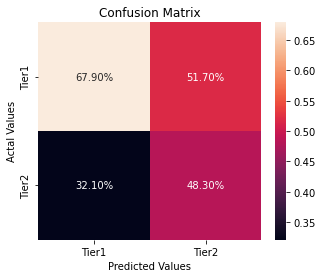

In [51]:
cm_bayes = confusion_matrix(y_test, y_pred_bayes)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_bayes = pd.DataFrame(cm_bayes,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_bayes/np.sum(cm_df_bayes), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [52]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           1       0.68      0.24      0.36      1365
           2       0.48      0.86      0.62      1123

    accuracy                           0.52      2488
   macro avg       0.58      0.55      0.49      2488
weighted avg       0.59      0.52      0.47      2488



In [53]:
# print the accuracy score of each model:
print('----------------------------------------')
print('Accuracy')
print('----------------------------------------')
print('Naive Bayes Test Accuracy: ', accuracy_score(y_test, y_pred_bayes)*100,'%')
print('Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_RF)*100,'%')
print('Adaboost Test Accuracy: ', accuracy_score(y_test, y_pred_Ada)*100,'%')
print('Gradient Boost Test Accuracy: ', accuracy_score(y_test, y_pred_GBC)*100,'%')
print('Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_LR)*100,'%')

# Print the F1 score of each model:
print('\n----------------------------------------')    
print('Weighted F1 Score')
print('----------------------------------------')
print('Naive Bayes F1 Score: ', f1_score(y_test, y_pred_bayes, average='weighted'))
print('Random Forest F1 Score: ', f1_score(y_test, y_pred_RF, average='weighted'))
print('Adaboost F1 Score: ', f1_score(y_test, y_pred_Ada, average='weighted'))
print('Gradient Boost F1 Score: ', f1_score(y_test, y_pred_GBC, average='weighted'))
print('Logistic Regession F1 Score: ', f1_score(y_test, y_pred_LR, average='weighted'))


----------------------------------------
Accuracy
----------------------------------------
Naive Bayes Test Accuracy:  52.13022508038585 %
Random Forest Test Accuracy:  65.83601286173634 %
Adaboost Test Accuracy:  65.59485530546624 %
Gradient Boost Test Accuracy:  63.7459807073955 %
Logistic Regession Test Accuracy:  64.34887459807074 %

----------------------------------------
Weighted F1 Score
----------------------------------------
Naive Bayes F1 Score:  0.47496468108834894
Random Forest F1 Score:  0.6586293578423997
Adaboost F1 Score:  0.6567302615218763
Gradient Boost F1 Score:  0.6362057387956687
Logistic Regession F1 Score:  0.6400484470989276
